# HYFN Capstone Project 
## --- Prediction of engagements in advertisement campaign

### Part 1: Data preparation

In this project, I am using the PostgreSQL interface in Python to access the database on cluster. Since I am focusing on the modeling of campaign level, the table I am interested are :  
1. facebook_daily_campaign_stats  
2. fb_ads_campaign_groups
3. fb_ads_accounts

Table 1 and 2 are first joined by column "campaign_id", the combined table are then joined with table 3 by column "account_id". 

In [1]:
#!/usr/bin/python
#-*- coding: utf-8 -*-
import psycopg2
import sys

import pandas as pd
import numpy as np

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime, timedelta
import matplotlib.dates as mdates

In [2]:
con = None

try:
     
    con = psycopg2.connect(host='hyfn8-cluster-test.cbftndreyyap.us-east-1.redshift.amazonaws.com',
                           port = 5439, database='dev', user='johnnyzhang', password='HYFN-Capstone-2017-$') 
    cur = con.cursor()
    
    query_cmd = '''\
    SELECT stats.*, campaigns.objective, accounts.name, accounts.account_id FROM facebook_daily_campaign_stats stats\
    LEFT JOIN fb_ads_campaign_groups campaigns\
    ON stats.campaign_id = campaigns.service_id\
    LEFT JOIN fb_ads_accounts accounts\
    ON campaigns.account_id = accounts.id;\
    '''
    fb_campaign_df = pd.read_sql_query(query_cmd, con = con, parse_dates = ['date_start', 'date_stop'])
    

except psycopg2.DatabaseError, e:
    print 'Error %s' % e    
    sys.exit(1)
    

finally:
    if con:
        con.close()

** Table summaries**  
The table "fb_daily_campaign_stats" has 46829 rows in total. However, only 20786 ones have valid "account_id" and associated "objective" after joining.   
We will also only look at the campaign records with objective "LINK_CLICKS", since our aim is to model the relationship between "spend" and "website click". Ad campaign with other objectives may have significantly non-proportional relation between these two variables. The final data point is 6865.  

Example of final data table is named "fb_link_df" and sample rows are also given below.

In [3]:
select_cols = ['account_id','campaign_id','date_start','spend','inline_link_clicks','objective','name']
fb_df = fb_campaign_df[select_cols]
fb_link_df = fb_df[fb_df.objective == 'LINK_CLICKS']

In [4]:
# Convert account_id to string
temp = ['{:.0f}'.format(x) for x in fb_link_df.account_id]
fb_link_df.loc[fb_link_df.index,'account_id'] = temp

/Applications/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [5]:
fb_link_df = fb_link_df[fb_link_df.spend > 0]
fb_link_df = fb_link_df[fb_link_df.inline_link_clicks > 0]

** Sample table content:**

In [6]:
fb_link_df.head()

,account_id,campaign_id,date_start,spend,inline_link_clicks,objective,name
0,1012201575494245,6047406179103,2016-05-21,10740.44,2078.0,LINK_CLICKS,Target
13,868189209895483,6054162669769,2016-09-20,11.71,19.0,LINK_CLICKS,Visit California
14,868189209895483,6053469024769,2016-09-20,78.59,249.0,LINK_CLICKS,Visit California
58,345009516,6050553503720,2016-09-21,17.98,16.0,LINK_CLICKS,All Clients - LIN Digital
59,345009516,6049461694920,2016-09-21,16.00,20.0,LINK_CLICKS,All Clients - LIN Digital


**Table summary:**

In [7]:
num_account = fb_link_df.account_id.value_counts().shape
num_campaign = fb_link_df.campaign_id.value_counts().shape

print 'Total number of account : %i\nTotal number of campaign: %i' %(num_account[0], num_campaign[0])
print 'The time frame is from %s to %s' %(min(fb_link_df.date_start),max(fb_link_df.date_start))

Total number of account : 32
Total number of campaign: 194
The time frame is from 2016-04-18 00:00:00 to 2016-12-20 00:00:00


### Part 2: Data modeling 
### 2.1 Ex post model

1.Convert "campaign_id" into category data(dummy variables)

In [8]:
link_ml_df = pd.concat([fb_link_df, pd.get_dummies(fb_link_df.campaign_id,drop_first=True)], axis = 1)

2.Transform "spend" and "inline_link_clicks" into logrithmic scale

In [9]:
link_ml_df.loc[link_ml_df.index,'log_spend'] = np.log(link_ml_df.spend)
link_ml_df.loc[link_ml_df.index,'log_click'] = np.log(link_ml_df.inline_link_clicks)

3.Drop the redundant columns

In [10]:
link_ml_df.drop(['account_id','campaign_id','date_start','objective','name','spend','inline_link_clicks'], axis = 1, inplace = True)

Data Frame "link_ml_df" ready for machine learning

In [11]:
link_ml_df.head()

,23842505131670746,23842505131810746,23842505131840746,23842505782680162,23842506958430737,23842507000030737,23842507560460491,23842508340700491,23842509683750746,23842509683770746,...,6064002893844,6064003490044,6064004160044,6064663893217,6064969908417,6064970231017,6066725507025,6067165333617,log_spend,log_click
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.281771,7.639161
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.460443,2.944439
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.364244,5.517453
58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.889260,2.772589
59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.772589,2.995732


### Regression Model 1:

\begin{equation*}
log(Clicks) = m* log(spend)+b_{campaign}+b_{int}
\end{equation*}

In this project, I am going to use the ski-learn(ML package built in Python) for various regression problems.

In [12]:
from sklearn import linear_model
from sklearn import cross_validation
from sklearn import metrics

linreg = linear_model.LinearRegression(fit_intercept=True)  # This is the default
X = link_ml_df.copy()
X.drop('log_click', axis = 1, inplace = True)
y = link_ml_df.log_click
linreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

**Spend coefficients**:

In [13]:
print "The spend coefficients between log(spend) and log(clicks) (m) is %.2f" % linreg.coef_[-1]

The spend coefficients between log(spend) and log(clicks) (m) is 0.91


**In-sample prediction metric**:

In [14]:
print "The in-sample prediction R^2 is %.4f" % linreg.score(X,y)
print "The mean squared error in model is %.4f" % metrics.mean_squared_error(y,linreg.predict(X))

The in-sample prediction R^2 is 0.9468
The mean squared error in model is 0.1534


**Visualization**

In [15]:
x0 = X.loc[X.index[0]] 
X0 = pd.DataFrame({}, columns = X.columns)
X0 = X0.append([x0]*50,ignore_index=True)
X0['log_spend'] = pd.Series(np.linspace(0, 10, 50))

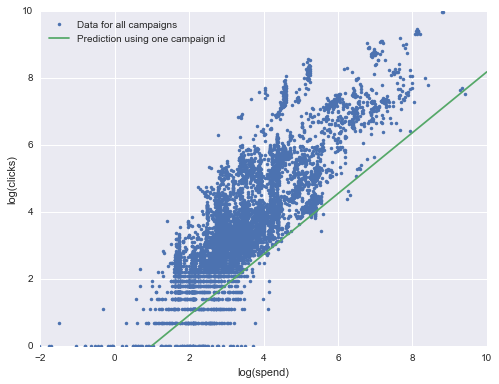

In [16]:
plt.figure(figsize=(8,6))
plt.plot(X.log_spend, y, '.')
plt.plot(X0.log_spend, linreg.predict(X0), '-')
plt.xlabel('log(spend)')
plt.ylabel('log(clicks)')
plt.axis([-2, 10, 0, 10])
plt.legend(['Data for all campaigns','Prediction using one campaign id'],loc='best')

**Coefficients of Regression model (variation in campaigns $b_{campaign}$)** 

In [17]:
coeffs = linreg.coef_[:-1]

In [18]:
avg_clicks_campaign = fb_link_df[['campaign_id','inline_link_clicks']].groupby('campaign_id').mean()

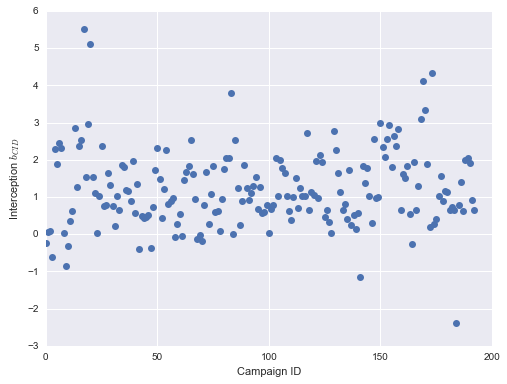

In [19]:
plt.figure(figsize=(8,6))
plt.plot(coeffs,'o')
plt.xlabel('Campaign ID')
plt.ylabel('Interception $b_{CID}$')
#plt.axis([0, 12, -2, 6])

Now, we can compare the effectiveness of various campaign. From the plot, it seems most of the campaign are close and in a clustered way. However, there are some outliers as well. It may be interesting to look at those campaign individually and see what are the reasons for these differences.

Before building the ex ante model, we can also do a cross-validation on our current model to evaluate its ability.

### Cross-validation

split the data set into training data (70%) and testing data (30%).

In [23]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=50)
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
mse_test = metrics.mean_squared_error(y_test, y_pred)

In [24]:
from math import e

In [25]:
factor1 = e**(-np.sqrt(mse_test))
factor2 = e**(np.sqrt(mse_test))
print "The mean squared error in test data set is %.4f" %mse_test
print "In prediction of link clicks, this error corresponds to a factor between %.2f to %.2f" %(factor1,factor2)

The mean squared error in test data set is 0.1678
In prediction of link clicks, this error corresponds to a factor between 0.66 to 1.51
